# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see README.md *

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- We find the best value of k using crossvalidation.

In this exercise you will implement these steps and understand the basic Image Classification pipeline and cross-validation.

You can choose if you implement the distance computation using a fully vectorized version, or using one or two for-loops. 
Vectorization is going to be much faster than using for loops, but using two for loops is perhaps the most straightforward implementation. 

We will work on the CIFAR-10 image data, which is a common dataset with 10 object classes. To make computation fast,  the images are small, 32x32x3 (RGB) pixels. 


You work on the notebook by pressing shift+enter on a cell. Note that all cells must be run in correct order. 

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from inf5860.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'inf5860/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


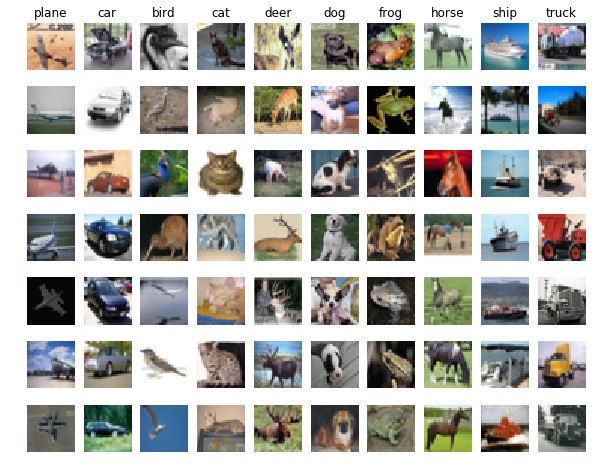

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape data

It is common to reshape the images to a long vector of size [32x32x3]

In [5]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:

from inf5860.classifiers.k_nearest_neighbor import KNearestNeighbor
# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)


## Do the classication

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `inf5860/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances` that  computes the euclidean distance between all pairs of (test, train) examples.

You can choose to implement the distance  using for loops (slow), or using full vectorization (no for loops over the samples).

In [7]:
# Open inf5860/classifiers/k_nearest_neighbor.py and implement
# compute_distances.

# Test your implementation:
dists = classifier.compute_distances(X_test)


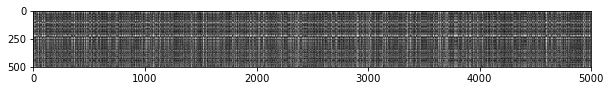

In [8]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

In [9]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

To avoid confusion, we do the  splitting the training data into a set used for training and a set used for validation, and estimate the classification accuracy on the validation part, with the current value of k, then we iteratate over different values of k. We use num_folds folds in cross-validation.

The 5000 training images are split into 5 subsets of 1000 samples. For fold n , you train on the other folds (4000 samples) and test on fold n (1000 samples). 

In [11]:
num_folds = 5

X_train_folds = np.array_split(X_train, num_folds)

y_train_folds = np.array_split(y_train, num_folds)
[sampsize,nsamp] = X_train_folds[1].shape





Below, you should implement cross-validation to find the best value of k.  For each value of k, we have one fold (1000 samples) for validation and 4 folds (4000 samples) for training.  For a given k, the accuracy if found by looping over the validation folds and computing the average accuracy over the 5  validation folds. This should be assigned to accuracy below. To compute this, you need to classify the validation folds (and thus compute the distances to the corresponding training samples also). 

In [12]:


# Here we build a dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

k_to_accuracies = {}
nk = len(k_choices)

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################




for k in k_choices:
    
        for f in range(0,num_folds):
            # Take out all other folds   
            x_test_folds = np.empty((0,X_train_folds[0].shape[1]))
            y_test_folds = np.empty((0))
            for i in range(0,num_folds):
                if i!= f:
                    x_test_folds = np.vstack((x_test_folds,X_train_folds[i]))
                    y_test_folds = np.hstack((y_test_folds,y_train_folds[i]))
            
            x_validation_fold = X_train_folds[f]
            y_validation_fold = y_train_folds[f]
            # Test on current fold
            
            classifier = KNearestNeighbor()
            classifier.train(x_test_folds, y_test_folds)
            d = classifier.compute_distances(x_validation_fold)
            y_pred = classifier.predict_labels(d, k)         
            
            
            # Set accuracy to the accuracy on the current test fold accuracy
            num_correct = np.sum(y_pred == y_validation_fold)
            accuracy = float(num_correct) / len(y_validation_fold)
           
            k_to_accuracies[k] = k_to_accuracies.get(k,[]) + [accuracy]
              
            
            
    
            
            
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

0.263
0.257
0.264
0.278
0.266
0.239
0.249
0.24
0.266
0.254
0.248
0.266
0.28
0.292
0.28
0.262
0.282
0.273
0.29
0.273
0.265
0.296
0.276
0.284
0.28
0.26
0.295
0.279
0.283
0.28
0.252
0.289
0.278
0.282
0.274
0.27
0.279
0.279
0.282
0.285
0.271
0.288
0.278
0.269
0.266
0.256
0.27
0.263
0.256
0.263
k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k

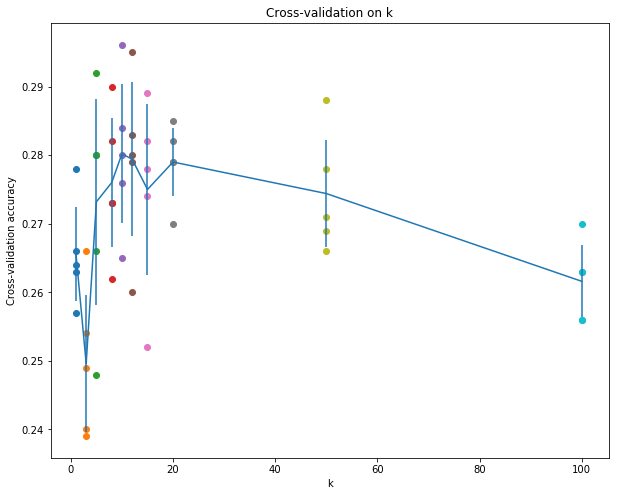

In [13]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [15]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.

## To do: set best_k to the value that gave the highest accuracy during crossvalidation. 
best_k = 5



classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000
